<a href="https://colab.research.google.com/github/IsaacFigNewton/DisCoFuzz/blob/main/DisCoFuzz_WF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Config

## Download, install dependencies

In [368]:
!pip install POT

## Import

In [369]:
from typing import Callable, Dict, List, Tuple, Set
import math
import numpy as np
import random
import nltk

nltk.download('wordnet')
nltk.download('framenet-17')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn
from nltk.corpus import framenet as fn
from nltk.corpus import stopwords

import spacy

import pandas as pd

import scipy.stats as stats
from scipy.special import expit, logit

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

import tensorflow as tf

import ot

from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading framenet-17: Package 'framenet-17' not found
[nltk_data]     in index
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Config

In [370]:
all_synsets = list(wn.all_synsets())
wn_dict = {
    'synset': list(),
    'lemmas': list(),
    'antonyms': list(),
    'gloss': list()
}

for s in all_synsets:
  lemmas = s.lemmas()
  antonyms = list()
  for lemma in lemmas:
    antonyms += list(lemma.antonyms())
  if len(lemmas) > 1 and len(antonyms) > 0:
    wn_dict['synset'].append(s.name())
    wn_dict['lemmas'].append([l.name() for l in lemmas])
    wn_dict['antonyms'].append([a.name() for a in antonyms])
    wn_dict['gloss'].append(s.definition())

wn_df = pd.DataFrame.from_dict(wn_dict)
wn_df.head()

,synset,lemmas,antonyms,gloss
0,abaxial.a.01,"[abaxial, dorsal]",[adaxial],facing away from the axis of an organ or organism
1,adaxial.a.01,"[adaxial, ventral]",[abaxial],nearest to or facing toward the axis of an org...
2,abducent.a.01,"[abducent, abducting]",[adducent],especially of muscles; drawing away from the m...
3,adducent.a.01,"[adducent, adductive, adducting]",[abducent],especially of muscles; bringing together or dr...
4,relative.a.01,"[relative, comparative]",[absolute],estimated by comparison; not absolute or complete


In [371]:
wn_df = wn_df.sample(frac=0.1).reset_index(drop=True)
print(f'Number of synsets: {len(wn_df)}')

Number of synsets: 267


In [372]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [373]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

## Embedding Helper Class

In [374]:
class LemmaVectorizer:
    def __init__(self, jit_vectorization = False):
        self.embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
        self.keyed_vectors = None
        if not jit_vectorization:
          self.keyed_vectors = self.build_wordnet_lemma_embeddings()

    def build_wordnet_lemma_embeddings(
        self,
        batch_size: int = 64
    ):
        """
        Loads all WordNet lemmas, embeds them using a SentenceTransformer model,
        and returns a dictionary mapping lemma → embedding vector.

        Args:
            batch_size: Batch size for model.encode().

        Returns:
            dict[str, np.ndarray]: mapping from lemma string to embedding vector.
        """
        # Collect all lemmas (set removes duplicates)
        lemma_set = set()
        for syn in wn.all_synsets():
            for lemma in syn.lemmas():
                lemma_set.add(lemma.name().replace("_", " "))  # normalize underscore → space

        lemma_list = sorted(lemma_set)

        # Encode lemmas in batches
        embeddings = self.embedding_model.encode(
            lemma_list,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True
        )

        # Build dictionary
        lemma_to_vec = {lemma: emb for lemma, emb in zip(lemma_list, embeddings)}

        return lemma_to_vec

    def __call__(self, X: str) -> np.ndarray:
        if self.keyed_vectors:
            v = self.keyed_vectors.get(X)#.lemma_.lower())
            if v is not None:
                return np.asarray(v, dtype=float)
        return self.embedding_model.encode([X])

# Fuzzification Classes

## WF Geodesic Calculator
I had to modify the geodesic calculation functions from [the work by Elsa Cazelles, Arnaud Robert, Felipe Tobar](https://github.com/GAMES-UChile/Wasserstein-Fourier.git) in their paper ["The Wasserstein-Fourier Distance for Stationary Time Series"](https://arxiv.org/abs/1912.05509) to make it compatible with the component-wise series representation I'm using for gaussians.

In [375]:
import numpy as np
import ot


class WFGeodesic:
  def __init__(self, kernel_size:int, num_interpolants:int, reg:float=1e-5):
    """
      kernel_size    :      number of frequencies to track
      num_interpolants     : number of interpolant
    """
    # in the paper, they did just used frequencies represented by np.linspace(-40,40,601)
    #   to simplify things, I'm only using positive frequencies
    self.kernel = np.array([i for i in range(kernel_size)])
    self.num_interpolants = num_interpolants
    self.reg = 1e-5

  def get_geodesic(self, h1, h2):

      """

      Compute the geodesic in the Wasserstein space between two distributions

      Parameters
      ----------

      h1 and h2  : 2D arrays for the sine and cosine frequency components

      Returns
      -------

      supports   : supports of the n_step interpolants
      values     : n_step interpolants (histograms)

      """

      u, v = np.meshgrid(self.kernel, self.kernel)
      cost = (u-v)**2
      cost = np.ascontiguousarray(cost, dtype='float64')

      cos_plan = ot.emd(np.ascontiguousarray(h1[0]), np.ascontiguousarray(h2[0]), cost)
      sin_plan = ot.emd(np.ascontiguousarray(h1[1]), np.ascontiguousarray(h2[1]), cost)
      taus = np.linspace(0, 1, self.num_interpolants)
      supports = np.zeros((2, len(self.kernel)))
      values = np.zeros((2, len(self.kernel)))
      for tau in taus:
          bar_support = {"cos": dict(), "sin": dict()}
          for idx_i, i in enumerate(self.kernel):
              for idx_j, j in enumerate(self.kernel):
                  # add supports and values for cos component of plan
                  if cos_plan[idx_i, idx_j] > 0:
                      support_idx = tau*i + (1-tau)*j
                      if support_idx not in bar_support["cos"]:
                          bar_support["cos"][support_idx] =  cos_plan[idx_i, idx_j]
                      bar_support["cos"][support_idx] +=  cos_plan[idx_i, idx_j]
                  # add supports and values for sin component of plan
                  if sin_plan[idx_i, idx_j] > 0:
                      support_idx = tau*i + (1-tau)*j
                      if support_idx not in bar_support["sin"]:
                          bar_support["sin"][support_idx] =  sin_plan[idx_i, idx_j]
                      bar_support["sin"][support_idx] +=  sin_plan[idx_i, idx_j]

          # set values for supports and values of different components
          for i, (s, v) in enumerate(bar_support["cos"].items()):
            supports[0][i] = s
            values[0][i] = v
          for i, (s, v) in enumerate(bar_support["sin"].items()):
            supports[1][i] = s
            values[1][i] = v

      return supports, values


  # def get_geodesic_entropy(self, h1, h2):
  #     """

  #     Compute the geodesic between two distributions from entropy regularized from the Wasserstein space

  #     Parameters
  #     ----------

  #     h1 and h2  : 2D arrays for the sine and cosine frequency components

  #     Returns
  #     -------

  #     supports   : supports of the n_step interpolants
  #     values     : n_step interpolants (histograms)

  #     """

  #     # compute cost
  #     u, v = np.meshgrid(self.kernel, self.kernel)
  #     cost = (u-v)**2
  #     cost = np.ascontiguousarray(cost, dtype='float64')

  #     A = np.transpose((h1,h2))
  #     taus = np.linspace(0, 1, self.num_interpolants)

  #     supports = []
  #     values = []
  #     for tau in taus:
  #         w = np.array([1 - tau, tau])
  #         values.append(ot.bregman.barycenter(A, cost, self.reg, w))
  #         supports.append(self.kernel)

  #     return supports, values

## FourierFuzzifier

In [1184]:
import tensorflow as tf
import numpy as np
from typing import List, Union
import ot

class FourierFuzzifier:
    """TensorFlow-accelerated version of FourierFuzzifier with set operations"""

    def __init__(self, sigma: float, kernel_size: int):
        if kernel_size < 1:
            raise ValueError("Kernel size must be at least 1")
        self.kernel_size = kernel_size
        self.k_values = tf.cast(tf.range(0, kernel_size), tf.complex64)
        self.sigma = tf.constant(sigma, dtype=tf.complex64)

        # Pre-compute Fourier coefficients for all k values
        # C_k = e^{-\frac{a^{2}k^{2}}{2}} and keep mu portion separate for now
        c_k = tf.exp(-0.5 * (self.sigma ** 2) * (self.k_values ** 2))
        self.fourier_coeffs = c_k / (2 * np.pi)

    def _get_gaussian_at_mu_batch(self, mu: tf.Tensor) -> tf.Tensor:
        """
        Batch computation of Fourier series for Gaussians centered at multiple mu values.
        mu: shape (batch_size,)
        Returns: shape (batch_size, kernel_size)
        """
        # mu part of C_n = e^{-ikb}
        #   combine mu.shape = (batch_size,) with self.k_values.T.shape = (,self.kernel_size)
        #   to get tensor of shape (batch_size, self.kernel_size)
        mu_c_k = tf.linalg.matmul(
            tf.expand_dims(tf.cast(mu, dtype=tf.complex64), axis=1),
            tf.expand_dims(self.k_values, axis=0)
        )
        mu_c_k = tf.exp(-1j * mu_c_k)

        # combine (batch_size, self.kernel_size) with (self.kernel_size,) self.fourier_coeffs
        return self._normalize_batch(mu_c_k * self.fourier_coeffs)

    def _integrate_batch(self, a: tf.Tensor) -> tf.Tensor:
        """
        Batch integration.
        a: shape (batch_size, kernel_size)
        Returns: shape (batch_size,)
        """
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")

        # Handle k=0 case separately (constant term)
        # For k=0, integral of constant from 0 to 1 is just the coefficient
        constant_term = a[:, 0:1] * tf.ones([tf.shape(a)[0], 1], dtype=tf.complex64)

        # Handle k > 0 terms
        divisor = 1j * self.k_values[1:]  # Skip k=0
        divisor = tf.expand_dims(divisor, axis=0)
        divisor = tf.broadcast_to(
            divisor,
            [tf.shape(a)[0], self.kernel_size - 1]
        )

        upper_bound = tf.exp(divisor * 1)
        lower_bound = tf.exp(divisor * 0)

        antiderivs = a[:, 1:] / divisor  # Skip k=0 term
        integrals_k_nonzero = tf.reduce_sum(
            antiderivs * (upper_bound - lower_bound),
            axis=1
        )

        # Combine k=0 and k>0 terms
        integrals = tf.squeeze(constant_term, axis=1) + integrals_k_nonzero
        return integrals

    def _integrate(self, a: tf.Tensor) -> tf.Tensor:
        """
        Single integration helper.
        a: shape (kernel_size)
        Returns: scalar
        """
        if len(tf.shape(a)) != 1:
            raise ValueError(f"Input tensor must have shape (kernel_size,), received tensor of shape {tf.shape(a)}")

        a_batch = tf.expand_dims(a, axis=0)
        result_batch = self._integrate_batch(a_batch)
        return tf.squeeze(result_batch)

    def _normalize_batch(self, a: tf.Tensor) -> tf.Tensor:
        """
        Batch normalization of probability density functions.
        a: shape (batch_size, kernel_size)
        """
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")

        total_integral = self._integrate_batch(a)  # (batch_size,)
        total_integral = tf.expand_dims(total_integral, 1)  # (batch_size, 1)

        # Avoid division by zero
        total_integral = tf.where(
            tf.abs(total_integral) > 1e-10,
            total_integral,
            tf.ones_like(total_integral)
        )

        return a / total_integral

    def _normalize(self, a: tf.Tensor) -> tf.Tensor:
        """
        Single normalization helper for normalizing probability density functions.
        a: shape (kernel_size,)
        Returns: shape (kernel_size,)
        """
        if len(tf.shape(a)) != 1:
            raise ValueError(f"Input tensor must have shape (kernel_size,), received tensor of shape {tf.shape(a)}")

        a_batch = tf.expand_dims(a, axis=0)
        result_batch = self._normalize_batch(a_batch)
        return tf.squeeze(result_batch, axis=0)

    def _convolve_batch(self, a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
        """
        Batch convolution using FFT.
        a, b: shape (batch_size, kernel_size)
        Returns: shape (batch_size, kernel_size)
        """
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
        if len(tf.shape(b)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(b)}")

        # Batch FFT convolution
        A_fft = tf.signal.fft(tf.cast(a, tf.complex64))
        B_fft = tf.signal.fft(tf.cast(b, tf.complex64))
        C_fft = A_fft * B_fft
        C = tf.signal.ifft(C_fft)

        return tf.cast(C, tf.complex64)

    def _convolve(self, a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
        """
        Single convolution helper.
        a, b: shape (kernel_size,)
        Returns: shape (kernel_size,)
        """
        a_batch = tf.expand_dims(a, axis=0)
        b_batch = tf.expand_dims(b, axis=0)
        result_batch = self._convolve_batch(a_batch, b_batch)
        return tf.squeeze(result_batch, axis=0)

    def _differentiate_batch(self, a: tf.Tensor) -> tf.Tensor:
        """
        Batch differentiation.
        a: shape (batch_size, kernel_size)
        Returns: shape (batch_size, kernel_size)
        """
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")

        return a * tf.exp(1j * self.k_values)

    def _differentiate(self, a: tf.Tensor) -> tf.Tensor:
        """
        Single differentiation helper.
        a: shape (kernel_size,)
        Returns: shape (kernel_size,)
        """
        a_batch = tf.expand_dims(a, axis=0)
        result_batch = self._differentiate_batch(a_batch)
        return tf.squeeze(result_batch, axis=0)

    # SET OPERATIONS
    def fuzzify(self, component: float) -> tf.Tensor:
        """
        Convert a real-valued component to a Fourier series representation of a Gaussian.
        component: scalar float
        Returns: shape (kernel_size,)
        """
        mu = tf.constant([component], dtype=tf.float32)
        gaussian = self._get_gaussian_at_mu_batch(mu)
        normalized = self._normalize_batch(gaussian)
        return tf.squeeze(normalized, axis=0)

    def fuzzify_batch(self, components: tf.Tensor) -> tf.Tensor:
        """
        Batch fuzzification.
        components: shape (batch_size,)
        Returns: shape (batch_size, kernel_size)
        """
        if len(tf.shape(components)) != 1:  # Fixed: was checking for 3
            raise ValueError(f"Input tensor must have shape (batch_size,), received tensor of shape {tf.shape(components)}")

        gaussians = self._get_gaussian_at_mu_batch(components)
        return self._normalize_batch(gaussians)

    def negation(self, a: tf.Tensor) -> tf.Tensor:
        """
        Fuzzy negation: NOT(a) = 1 - a
        a: shape (kernel_size,)
        Returns: shape (kernel_size,)
        """
        # Create representation of constant function 1
        one = tf.zeros_like(a)
        one = tf.tensor_scatter_nd_update(
            one, [[0]], [tf.constant(1.0, dtype=tf.complex64)]  # Fixed type
        )

        return self._normalize(one - a)

    def negation_batch(self, a: tf.Tensor) -> tf.Tensor:
        """
        Batch fuzzy negation: NOT(a) = 1 - a
        a: shape (batch_size, kernel_size)
        Returns: shape (batch_size, kernel_size)
        """
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
        batch_size = tf.shape(a)[0]

        # Create batch of constant function 1
        ones = tf.zeros_like(a)
        indices = tf.stack([
            tf.range(batch_size),
            tf.zeros(batch_size, dtype=tf.int32)
        ], axis=1)
        updates = tf.ones([batch_size], dtype=tf.complex64)  # Fixed: proper shape and type
        ones = tf.tensor_scatter_nd_update(ones, indices, updates)

        return self._normalize_batch(ones - a)

    def intersection(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Fuzzy intersection using product (min approximation).
        a, b: shape (kernel_size,)
        Returns: shape (kernel_size,)
        """
        result = self._convolve(a, b)
        if normalize:
            result = self._normalize(result)
        return result

    def intersection_batch(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Batch fuzzy intersection using product.
        a, b: shape (batch_size, kernel_size)
        Returns: shape (batch_size, kernel_size)
        """
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
        result = self._convolve_batch(a, b)
        if normalize:
            result = self._normalize_batch(result)
        return result

    def union(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Fuzzy union: a + b - a*b
        a, b: shape (kernel_size,)
        Returns: shape (kernel_size,)
        """
        convolved = self._convolve(a, b)
        result = a + b - convolved
        if normalize:
            result = self._normalize(result)
        return result

    def union_batch(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Batch fuzzy union: a + b - a*b
        a, b: shape (batch_size, kernel_size)
        Returns: shape (batch_size, kernel_size)
        """
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
        convolved = self._convolve_batch(a, b)
        result = a + b - convolved
        if normalize:
            result = self._normalize_batch(result)
        return result

    def get_npsd_batch(self, a: tf.Tensor) -> tf.Tensor:
        # normalize the power spectral densities
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
        norms = tf.expand_dims(tf.math.reduce_sum(tf.abs(a), axis=1), axis=1)
        norms = tf.broadcast_to(
            norms,
            [tf.shape(a)[0], tf.shape(a)[1]]
        )
        return tf.abs(a) / norms

    def similarity(self, a: tf.Tensor, b: tf.Tensor) -> Union[float, np.ndarray]:
        """
        Compute similarity as cosine similarity in frequency domain.
        a, b: shape (kernel_size,)
        Returns: scalar similarity
        """
        return self.similarity_batch(
            tf.expand_dims(a, axis=0),
            tf.expand_dims(b, axis=0),
            method="cosine"  # Fixed: added default method
        )

    def similarity_batch(self, a: tf.Tensor, b: tf.Tensor, method: str) -> Union[float, np.ndarray]:
        """
        Batch computation of pairwise similarities.
        a, b: shape (batch_size, kernel_size)
        Returns: shape (batch_size,) - similarity for each pair
        """
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")

        flatten_layer = tf.keras.layers.Flatten()

        freqs = tf.range(0, self.kernel_size, dtype=tf.float32)
        freqs_2 = freqs * freqs
        # get frequencies^2
        freqs_2_batch = tf.broadcast_to(
            tf.expand_dims(freqs_2, axis=0),
            [tf.shape(a)[0], self.kernel_size]
        )
        freqs_2_batch = tf.cast(freqs_2_batch, tf.float32)
        freqs_2 = freqs_2.numpy()

        a_npsd = self.get_npsd_batch(a)
        if len(tf.shape(a_npsd)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a_npsd)}")
        b_npsd = self.get_npsd_batch(b)
        if len(tf.shape(b_npsd)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(b_npsd)}")

        # energy is proportional to frequency^2 * amplitude^2
        a_energy = a_npsd * a_npsd * freqs_2_batch
        b_energy = b_npsd * b_npsd * freqs_2_batch
        # Normalize to probability distributions
        a_energy = a_energy / tf.reduce_sum(a_energy, axis=1, keepdims=True)
        b_energy = b_energy / tf.reduce_sum(b_energy, axis=1, keepdims=True)

        # Replaced match/case with if/elif for Python <3.10 compatibility
        if method == "ot":
            a_energy_normed_numpy = a_energy.numpy()
            b_energy_normed_numpy = b_energy.numpy()

            u, v = np.meshgrid(freqs_2, freqs_2)
            cost = (u-v)**2
            cost = np.ascontiguousarray(cost, dtype='float64')

            total_cost = 0
            for i in range(a.shape[0]):
                plan = ot.emd(
                    np.ascontiguousarray(a_energy_normed_numpy[i, :]),
                    np.ascontiguousarray(b_energy_normed_numpy[i, :]),
                    cost,
                    check_marginals=False
                )
                total_cost += np.sum(plan * cost)

            return np.log1p(np.abs(total_cost / a.shape[0]))

        elif method == "cosine":
            # Removed debug print statement
            a_normed, a_norm = tf.linalg.normalize(
                tf.abs(a) * freqs_2_batch,
                axis=1  # Fixed: was axis=0, should be axis=1 for batch operations
            )
            b_normed, b_norm = tf.linalg.normalize(
                tf.abs(b) * freqs_2_batch,
                axis=1  # Fixed: was axis=0
            )
            a_normed_flat = flatten_layer(a_normed)
            b_normed_flat = flatten_layer(b_normed)
            numerator = tf.reduce_sum(a_normed_flat * b_normed_flat)
            denominator_a = tf.sqrt(tf.reduce_sum(a_normed_flat * a_normed_flat))
            denominator_b = tf.sqrt(tf.reduce_sum(b_normed_flat * b_normed_flat))

            similarity = numerator / (denominator_a * denominator_b + 1e-10)
            return similarity.numpy()

        else:
            raise ValueError(f"Unknown method: {method}")

## FuzzyFourierTensorTransformer

In [899]:
class FuzzyFourierTensorTransformer:
    """
    TensorFlow-accelerated fuzzy tensor transformer.
    All operations are vectorized and GPU-compatible.
    """

    def __init__(self, sigma: float = 0.1, kernel_size: int = 32):
        self.fuzzifier = FourierFuzzifier(sigma, kernel_size)
        self.kernel_size = kernel_size

    @tf.function
    def fuzzify(self, vect: tf.Tensor) -> tf.Tensor:
        """
        Vectorized fuzzification.
        vect: shape (d,) or (sample_size, d)
        Returns: shape (d,kernel_size) or (batch_size, d,kernel_size)
        """
        original_shape = tf.shape(vect)

        if len(original_shape) == 1:
            # Single vector case
            return self.fuzzifier._get_gaussian_at_mu_batch(vect)
        else:
            # Batch case
            batch_size = original_shape[0]
            fuzzy = [
                self.fuzzifier._get_gaussian_at_mu_batch(v)
                for v in tf.unstack(vect, axis=0)
            ]

            # Reshape to (batch_size, d, kernel_size)
            return tf.convert_to_tensor(fuzzy, dtype=tf.complex64)

    @tf.function
    def intersection(self, A: tf.Tensor, B: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Vectorized fuzzy intersection.
        A, B: shape (d,kernel_size)
        """
        # Flatten to process all at once
        if not len(A.shape) == 2:
          raise ValueError(f"A must be rank 2 tensors. Expected A.shape == 3, but got A.shape == {A.shape}")
        if not len(B.shape) == 2:
          raise ValueError(f"B must be rank 2 tensors. Expected A.shape == 3, but got A.shape == {B.shape}")

        result = self.fuzzifier._convolve_batch(A, B)

        if normalize:
            result = self.fuzzifier._normalize_batch(result)

        return result

    @tf.function
    def union(self, A: tf.Tensor, B: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Vectorized fuzzy union: A + B - A*B
        A, B: shape (d,kernel_size)
        """
        convolved = self.intersection(A, B, normalize=False)
        result = A + B - convolved

        if normalize:
            shape = tf.shape(result)
            if len(result.shape) == 3:
                result = self.fuzzifier._normalize_batch(result)
            else:
                result_flat = tf.reshape(result, [-1, self.kernel_size])
                result_flat = self.fuzzifier._normalize_batch(result_flat)
                result = tf.reshape(result_flat, shape)

        return result

    @tf.function
    def iterated_union(self, vects: tf.Tensor) -> tf.Tensor:
        """
        Efficiently compute union over multiple tensors.
        vects: shape (n_vects, d,kernel_size)
        """

        # if there's only 1 tensor to get the union
        if tf.shape(vects)[0] == 1:
            return vects[0]

        result = vects[0]
        for v in vects:
          # only include vect in union if it's the correct shape
          if len(v.shape) == 3:
              result = self.union(result, v, normalize=False)

        # Normalize the final result
        return self.fuzzifier._normalize_batch(result)

    def similarity(self, A: tf.Tensor, B: tf.Tensor, method:str = "ot") -> float:
        """
        Vectorized similarity computation.
        A, B: shape (d,kernel_size)
        Returns: scalar similarity between the normalized power spectral densities of A, B
        """
        return self.fuzzifier.similarity_batch(A, B, method)

# Dependency Composer Class

For assigning root of glosses' composition trees:
*   if the synset is for a verb, the first verb token is (almost) always the synset referent
*   if the synset is for an adverb, the first token after the word "with"/"without" is (almost) always the synset referent
*   if the synset is for an adjective, the first verb or adjective token is (almost) always the synset referent
*   if the synset is for a noun, the first noun token is (almost) always the synset referent


In [378]:
class SpacyDependencyComposer:
  def __init__(self,
      strategy:str="mean",
      spacy_model=None,
      lemma_vectorizer=None,
      fuzzifier=None
    ):
    self.stopwords = stopwords.words("english")
    self.strategy = strategy
    self.nlp = spacy.load("en_core_web_sm") if spacy_model is None else spacy_model
    self.lemma_vectorizer = LemmaVectorizer(True) if lemma_vectorizer is None else lemma_vectorizer
    self.fuzzifier = FuzzyFourierTensorTransformer() if fuzzifier is None else fuzzifier

  def _compose_tok_embedding(self, token) -> tf.Tensor:
    # lemma_vectorizer returns a numpy array, so convert it to tf.Tensor for fuzzification
    current_tok_tens = self.lemma_vectorizer(token.lemma_.lower())
    current_tok_tens = tf.convert_to_tensor(current_tok_tens, dtype=tf.float32)
    current_tok_tens = self.fuzzifier.fuzzify(current_tok_tens)[0]

    if token.children:
      # get all the childrens'embeddings
      child_embeddings = [
          self._compose_tok_embedding(c)
          for c in token.children
      ]

      if not child_embeddings:
        # If no valid children, return the current token's embedding
        return current_tok_tens

      # compose child embeddings based on strategy
      match self.strategy:
        case "mean":
          return tf.reduce_mean(tf.stack(child_embeddings), axis=0)
        case "intersection+mean":
          child_embeddings_intersected = [
              self.fuzzifier.intersection(current_tok_tens, c)
              for c in child_embeddings
          ]
          return tf.reduce_mean(tf.stack(child_embeddings_intersected), axis=0)
        case "intersection+union":
          child_embeddings_intersected = [
              self.fuzzifier.intersection(current_tok_tens, c)
              for c in child_embeddings
          ]
          return self.fuzzifier.iterated_union(child_embeddings_intersected)
        case "selective_intersection+mean":
          # if the current token is a modifier of some kind, intersect it with all its children
          if token.pos_ in {"VERB", "ADJ", "ADV"}:
            child_embeddings_intersected = [
                self.fuzzifier.intersection(current_tok_tens, c)
                for c in child_embeddings
            ]
            return tf.reduce_mean(tf.stack(child_embeddings_intersected), axis=0)
          # otherwise, just return the mean of its children
          return tf.reduce_mean(tf.stack(child_embeddings), axis=0)
        case _:
          raise ValueError(f"Unknown strategy: {self.strategy}")

    # if the token is a leaf
    else:
      return current_tok_tens

  def __call__(self,
      text: str,
  ) -> tf.Tensor:
      # Drop stopwords before getting dependency parse
      clean_text = " ".join([t for t in text.split(" ") if t not in self.stopwords])

      doc = self.nlp(text)
      root_embeddings = []
      for sent in doc.sents:
          root_emb = self._compose_tok_embedding(sent.root)
          if root_emb is not None:
            root_embeddings.append(root_emb)

      if not root_embeddings:
          return None

      # get the average
      return tf.reduce_mean(tf.stack(root_embeddings), axis=0)

# Vectorize and fuzzify wn_df entries

In [379]:
def vectorize(strings: List[str]) -> tf.Tensor:
  vects = embedding_model.encode(strings)
  normalized_vects = (vects - np.min(vects))/(np.max(vects) - np.min(vects))
  return tf.convert_to_tensor(normalized_vects)

In [380]:
spacy_model = spacy.load("en_core_web_sm")
lemma_vectorizer = LemmaVectorizer(True)
fuzzifier = FuzzyFourierTensorTransformer()

## Get baseline vectors, tensors

In [381]:
wn_df['lemmas_vects'] = wn_df['lemmas'].apply(vectorize)
wn_df['lemmas_vects_fuzzy'] = wn_df['lemmas_vects'].apply(fuzzifier.fuzzify)

In [382]:
# get mean embedding for synset lemmas
wn_df['synset_vect'] = wn_df['lemmas_vects'].apply(lambda x: tf.reduce_mean(x, axis=0))
# get fuzzified synset embedding
wn_df['synset_vect_fuzzy'] = wn_df['synset_vect'].apply(fuzzifier.fuzzify)

In [383]:
wn_df['antonyms_vects'] = wn_df['antonyms'].apply(vectorize)
wn_df['antonyms_vects_fuzzy'] = wn_df['antonyms_vects'].apply(fuzzifier.fuzzify)

In [384]:
wn_df['gloss_vect'] = wn_df['gloss'].apply(vectorize)
# will evaluate compositional embedding similarity against gloss_vect_fuzzy
#   hence why we're fuzzifying here
wn_df['gloss_vect_fuzzy'] = wn_df['gloss_vect'].apply(fuzzifier.fuzzify)

## Apply different models/composition strategies

In [385]:
mean_composer = SpacyDependencyComposer(
    strategy="mean",
    spacy_model=spacy_model,
    lemma_vectorizer=lemma_vectorizer,
    fuzzifier=fuzzifier
)
intersection_mean_composer = SpacyDependencyComposer(
    strategy="intersection+mean",
    spacy_model=spacy_model,
    lemma_vectorizer=lemma_vectorizer,
    fuzzifier=fuzzifier
)
intersection_union_composer = SpacyDependencyComposer(
    strategy="intersection+union",
    spacy_model=spacy_model,
    lemma_vectorizer=lemma_vectorizer,
    fuzzifier=fuzzifier
)
selective_intersection_mean_composer = SpacyDependencyComposer(
    strategy="selective_intersection+mean",
    spacy_model=spacy_model,
    lemma_vectorizer=lemma_vectorizer,
    fuzzifier=fuzzifier
)

In [386]:
# get compositional embeddings for glosses using different strategies
wn_df["gloss_vect_fuzzy_composed_mean"] = wn_df["gloss"].apply(mean_composer)

In [387]:
wn_df["gloss_vect_fuzzy_composed_intersection_mean"] = wn_df["gloss"].apply(intersection_mean_composer)

In [388]:
wn_df["gloss_vect_fuzzy_composed_intersection_union"] = wn_df["gloss"].apply(intersection_union_composer)

In [389]:
wn_df["gloss_vect_fuzzy_composed_selective_intersection_mean"] = wn_df["gloss"].apply(selective_intersection_mean_composer)

# Test fuzzy embedding operators

In [1185]:
fuzzifier = FuzzyFourierTensorTransformer()
fuzzifier.fuzzifier.kernel_size

32

In [1186]:
# pick a random row in wn_df
row_idx = random.choice(wn_df.index)
# get the fourier tensors for the first lemma's fuzzy vect
fuzzy_tensors = wn_df.loc[row_idx, 'lemmas_vects_fuzzy']
fuzzy_vects = fuzzy_tensors[0]
intersected_components = fuzzifier.fuzzifier.intersection(fuzzy_vects[0], fuzzy_vects[1])

## Check integration

In [1187]:
print(f"Area under first component of first lemma's vector for synset {row_idx}: {fuzzifier.fuzzifier._integrate(fuzzy_vects[0])}")
print(f"Area under second component of first lemma's vector for synset {row_idx}: {fuzzifier.fuzzifier._integrate(fuzzy_vects[1])}")
print(f"Area under intersection of first 2 components of first lemma's vector for synset {row_idx}: {fuzzifier.fuzzifier._integrate(intersected_components)}")

Area under first component of first lemma's vector for synset 35: (0.579595685005188+0.02704499661922455j)
Area under second component of first lemma's vector for synset 35: (0.5787447094917297-0.14976313710212708j)
Area under intersection of first 2 components of first lemma's vector for synset 35: (1-1.4901161193847656e-08j)


## Check self-similarity

In [1188]:
print(f"Similarity of first lemma's vector for synset {row_idx} to itself: {fuzzifier.similarity(fuzzy_tensors[0], fuzzy_tensors[0])}")
print(f"Similarity of second lemma's vector for synset {row_idx} to itself: {fuzzifier.similarity(fuzzy_tensors[1], fuzzy_tensors[1])}")
print(f"Similarity of first lemma's vector for synset {row_idx} to second lemma's vector: {fuzzifier.similarity(fuzzy_tensors[0], fuzzy_tensors[1])}")

Similarity of first lemma's vector for synset 35 to itself: 7.269668740139502e-16
Similarity of second lemma's vector for synset 35 to itself: 1.6898759048628492e-16
Similarity of first lemma's vector for synset 35 to second lemma's vector: 6.496391036594557e-05


# Evaluate Inner Product

In [1189]:
sim = tf.keras.losses.CosineSimilarity(
    axis=-1,
    reduction='sum_over_batch_size',
    name='cosine_similarity'
)

In [1190]:
def cosine_similarity(a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
  return -1*sim(a, b).numpy()

In [1191]:
sample_size = 100
random_pairing_indices = [tuple(random.sample(range(len(wn_df)), 2)) for i in range(sample_size)]

eval_dict = {
    # for comparing synset-gloss IPs
    "syn_gloss_cosine_similarities": list(),
    "syn_gloss_fuzzy_similarities": list(),

    "syn_gloss_fuzzy_comp_mean_similarities": list(),
    "syn_gloss_fuzzy_comp_int_mean_similarities": list(),
    "syn_gloss_fuzzy_comp_int_union_similarities": list(),
    "syn_gloss_fuzzy_comp_sel_int_mean_similarities": list(),

    # for comparing lemma-lemma IPs
    "lemma_cosine_similarities": list(),
    "lemma_fuzzy_similarities": list(),

    # for comparing gloss-gloss IPs
    "gloss_gloss_cosine_similarities": list(),
    "gloss_gloss_fuzzy_similarities": list(),

    # for comparing syn-ant IPs
    "syn_ant_cosine_similarities": list(),
    "syn_ant_fuzzy_similarities": list(),
}

## Fuzzy space similarities

### Get similarities

In [1192]:
for a, b in random_pairing_indices:
  synset_vect = wn_df.loc[a, 'synset_vect']
  gloss_vect = wn_df.loc[a, 'gloss_vect']
  synset_vect_fuzzy = wn_df.loc[a, 'synset_vect_fuzzy']
  gloss_vect_fuzzy = wn_df.loc[a, 'gloss_vect_fuzzy']

  # syn-gloss similarities
  eval_dict["syn_gloss_cosine_similarities"].append(cosine_similarity(
      synset_vect,
      gloss_vect
  ))
  eval_dict["syn_gloss_fuzzy_similarities"].append(fuzzifier.similarity(
        synset_vect_fuzzy,
        gloss_vect_fuzzy
  ))

  # lemma-lemma similarities
  eval_dict["lemma_cosine_similarities"].append(cosine_similarity(
      wn_df.loc[a, 'lemmas_vects'][0],
      wn_df.loc[b, 'lemmas_vects'][0]
  ))
  eval_dict["lemma_fuzzy_similarities"].append(fuzzifier.similarity(
        wn_df.loc[a, 'lemmas_vects_fuzzy'][0],
        wn_df.loc[b, 'lemmas_vects_fuzzy'][0]
  ))

  # gloss-gloss similarities
  eval_dict["gloss_gloss_cosine_similarities"].append(cosine_similarity(
      gloss_vect,
      wn_df.loc[b, 'gloss_vect']
  ))
  eval_dict["gloss_gloss_fuzzy_similarities"].append(fuzzifier.similarity(
        gloss_vect_fuzzy,
        wn_df.loc[b, 'gloss_vect_fuzzy']
  ))

  # syn-ant similarities
  eval_dict["syn_ant_cosine_similarities"].append(cosine_similarity(
      synset_vect,
      np.mean(wn_df.loc[a, 'antonyms_vects'], axis=0)
  ))
  eval_dict["syn_ant_fuzzy_similarities"].append(fuzzifier.similarity(
        synset_vect_fuzzy,
        np.mean(wn_df.loc[a, 'antonyms_vects_fuzzy'], axis=0)
  ))

  # syn-custom gloss similarities
  eval_dict["syn_gloss_fuzzy_comp_mean_similarities"].append(fuzzifier.similarity(
        synset_vect_fuzzy,
        wn_df.loc[a, 'gloss_vect_fuzzy_composed_mean']
  ))
  eval_dict["syn_gloss_fuzzy_comp_int_mean_similarities"].append(fuzzifier.similarity(
        synset_vect_fuzzy,
        wn_df.loc[a, 'gloss_vect_fuzzy_composed_intersection_mean']
  ))
  eval_dict["syn_gloss_fuzzy_comp_int_union_similarities"].append(fuzzifier.similarity(
        synset_vect_fuzzy,
        wn_df.loc[a, 'gloss_vect_fuzzy_composed_intersection_union']
  ))
  eval_dict["syn_gloss_fuzzy_comp_sel_int_mean_similarities"].append(fuzzifier.similarity(
        synset_vect_fuzzy,
        wn_df.loc[a, 'gloss_vect_fuzzy_composed_selective_intersection_mean']
  ))

### Random lemma pairs

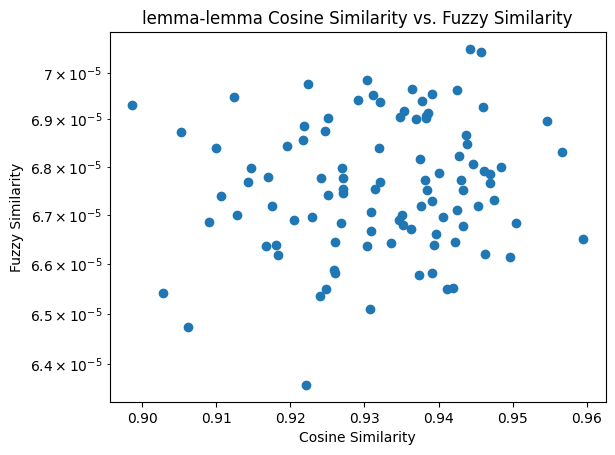

In [1193]:
plt.scatter(eval_dict["lemma_cosine_similarities"], eval_dict["lemma_fuzzy_similarities"])
plt.xlabel("Cosine Similarity")
plt.ylabel("Fuzzy Similarity")
plt.yscale("log")
plt.title("lemma-lemma Cosine Similarity vs. Fuzzy Similarity")
plt.show()

### gloss-gloss similarities

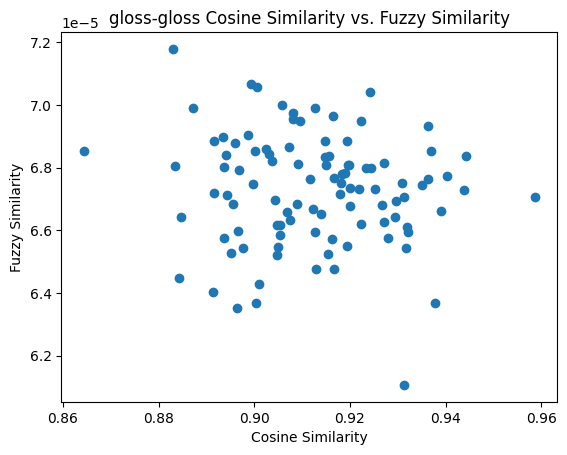

In [1194]:
plt.scatter(eval_dict["gloss_gloss_cosine_similarities"], eval_dict["gloss_gloss_fuzzy_similarities"])
plt.xlabel("Cosine Similarity")
plt.ylabel("Fuzzy Similarity")
plt.title("gloss-gloss Cosine Similarity vs. Fuzzy Similarity")
plt.show()

### Synset - gloss similarities

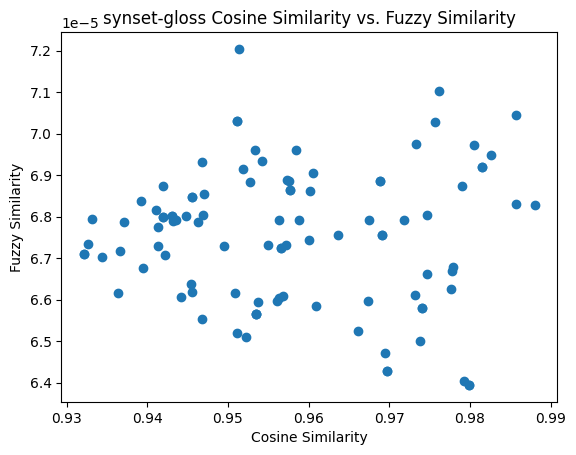

In [1214]:
# plot eval_df["cosine_similarities"] against eval_df["fuzzy_similarities"]
plt.scatter(eval_dict["syn_gloss_cosine_similarities"], eval_dict["syn_gloss_fuzzy_similarities"])
plt.xlabel("Cosine Similarity")
plt.ylabel("Fuzzy Similarity")
plt.title("synset-gloss Cosine Similarity vs. Fuzzy Similarity")
plt.show()

### synset-antonym similarities

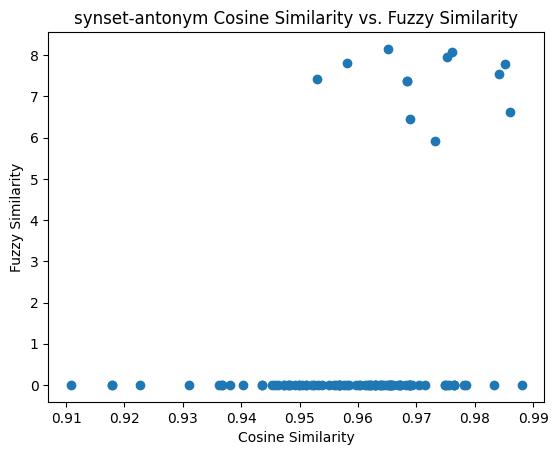

In [1196]:
# plot eval_df["cosine_similarities"] against eval_df["fuzzy_similarities"]
plt.scatter(eval_dict["syn_ant_cosine_similarities"], eval_dict["syn_ant_fuzzy_similarities"])
plt.xlabel("Cosine Similarity")
plt.ylabel("Fuzzy Similarity")
plt.title("synset-antonym Cosine Similarity vs. Fuzzy Similarity")
plt.show()

## Fuzzy gloss compositional embedding similarities

[np.float64(12.43201799865055), np.float64(11.97115678429779), np.float64(12.243590415443482), np.float64(10.795514130952022), np.float64(12.314206621911707), np.float64(11.827413357799045), np.float64(12.363561659600004), np.float64(12.363561659600004), np.float64(12.414017241005613), np.float64(12.361124398658077), np.float64(12.011889105656897), np.float64(12.29603926725141), np.float64(12.429399153214115), np.float64(12.413087870446565), np.float64(12.43694960426049), np.float64(12.480870298827039), np.float64(11.745860902527975), np.float64(12.29292832916415), np.float64(12.323017876219282), np.float64(12.011633746005963), np.float64(10.888339606290874), np.float64(12.370227081730976), np.float64(11.768756592075409), np.float64(12.343360955339055), np.float64(11.97115678429779), np.float64(11.569485255498023), np.float64(12.036853217717752), np.float64(12.294509975500635), np.float64(11.98591548798917), np.float64(12.310550426520587), np.float64(12.299136307497747), np.float64(12.

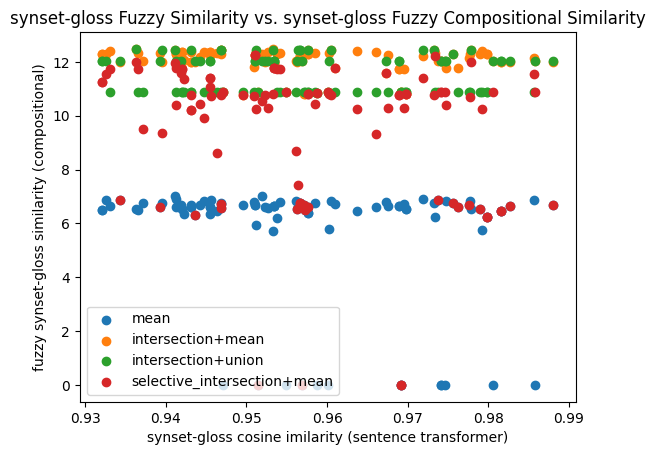

In [1197]:
print(eval_dict["syn_gloss_fuzzy_comp_int_mean_similarities"])
plt.scatter(eval_dict["syn_gloss_cosine_similarities"], eval_dict["syn_gloss_fuzzy_comp_mean_similarities"])
plt.scatter(eval_dict["syn_gloss_cosine_similarities"], eval_dict["syn_gloss_fuzzy_comp_int_mean_similarities"])
plt.scatter(eval_dict["syn_gloss_cosine_similarities"], eval_dict["syn_gloss_fuzzy_comp_int_union_similarities"])
plt.scatter(eval_dict["syn_gloss_cosine_similarities"], eval_dict["syn_gloss_fuzzy_comp_sel_int_mean_similarities"])
plt.xlabel("synset-gloss cosine imilarity (sentence transformer)")
plt.ylabel("fuzzy synset-gloss similarity (compositional)")
plt.legend(["mean", "intersection+mean", "intersection+union", "selective_intersection+mean"])
plt.title("synset-gloss Fuzzy Similarity vs. synset-gloss Fuzzy Compositional Similarity")
plt.show()

## Correlation coefficients

In [1198]:
eval_df = pd.DataFrame.from_dict(eval_dict)
# eval_df.head()

### IPs of different spaces

In [1199]:
# lemma-lemma
eval_df[["lemma_cosine_similarities", "lemma_fuzzy_similarities"]].corr()

,lemma_cosine_similarities,lemma_fuzzy_similarities
lemma_cosine_similarities,1.000000,0.117011
lemma_fuzzy_similarities,0.117011,1.000000


In [1200]:
eval_df[["gloss_gloss_cosine_similarities", "gloss_gloss_fuzzy_similarities"]].corr()

,gloss_gloss_cosine_similarities,gloss_gloss_fuzzy_similarities
gloss_gloss_cosine_similarities,1.000000,-0.098547
gloss_gloss_fuzzy_similarities,-0.098547,1.000000


In [1201]:
# synset-gloss
eval_df[["syn_gloss_cosine_similarities", "syn_gloss_fuzzy_similarities"]].corr()

,syn_gloss_cosine_similarities,syn_gloss_fuzzy_similarities
syn_gloss_cosine_similarities,1.000000,-0.026153
syn_gloss_fuzzy_similarities,-0.026153,1.000000


In [1202]:
# synset-antonym
eval_df[["syn_ant_cosine_similarities", "syn_ant_fuzzy_similarities"]].corr()

,syn_ant_cosine_similarities,syn_ant_fuzzy_similarities
syn_ant_cosine_similarities,1.000000,0.304842
syn_ant_fuzzy_similarities,0.304842,1.000000


### Strategies

In [1203]:
# fuzzy synset - fuzzy gloss vs fuzzy synset - fuzzy gloss composed embedding (mean)
eval_df[["syn_gloss_cosine_similarities", "syn_gloss_fuzzy_comp_mean_similarities"]].corr()

,syn_gloss_cosine_similarities,syn_gloss_fuzzy_comp_mean_similarities
syn_gloss_cosine_similarities,1.000000,-0.223244
syn_gloss_fuzzy_comp_mean_similarities,-0.223244,1.000000


In [1204]:
# fuzzy synset - fuzzy gloss vs fuzzy synset - fuzzy gloss composed embedding (intersection+mean)
eval_df[["syn_gloss_cosine_similarities", "syn_gloss_fuzzy_comp_int_mean_similarities"]].corr()

,syn_gloss_cosine_similarities,syn_gloss_fuzzy_comp_int_mean_similarities
syn_gloss_cosine_similarities,1.000000,-0.145921
syn_gloss_fuzzy_comp_int_mean_similarities,-0.145921,1.000000


In [1205]:
# fuzzy synset - fuzzy gloss vs fuzzy synset - fuzzy gloss composed embedding (intersection+union)
eval_df[["syn_gloss_cosine_similarities", "syn_gloss_fuzzy_comp_int_union_similarities"]].corr()

,syn_gloss_cosine_similarities,syn_gloss_fuzzy_comp_int_union_similarities
syn_gloss_cosine_similarities,1.000000,-0.056621
syn_gloss_fuzzy_comp_int_union_similarities,-0.056621,1.000000


In [1206]:
# fuzzy synset - fuzzy gloss vs fuzzy synset - fuzzy gloss composed embedding (selective intersection+mean)
eval_df[["syn_gloss_cosine_similarities", "syn_gloss_fuzzy_comp_sel_int_mean_similarities"]].corr()

,syn_gloss_cosine_similarities,syn_gloss_fuzzy_comp_sel_int_mean_similarities
syn_gloss_cosine_similarities,1.000000,-0.229075
syn_gloss_fuzzy_comp_sel_int_mean_similarities,-0.229075,1.000000


# Stat analysis

## Comparing IPs

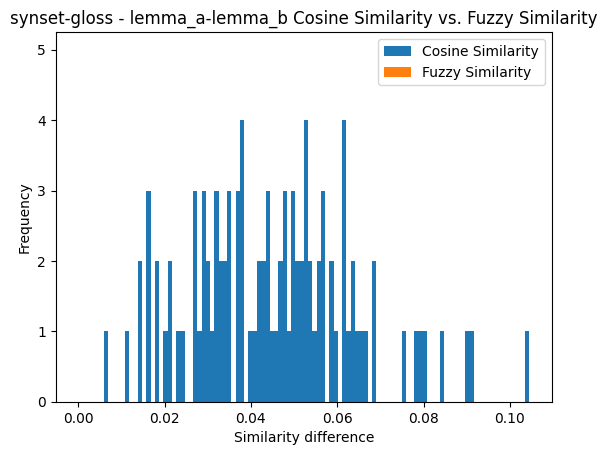

In [1207]:
eval_df["separability_fuzzy"] = eval_df["syn_gloss_fuzzy_similarities"] - eval_df["gloss_gloss_fuzzy_similarities"]
eval_df["separability"] = eval_df["syn_gloss_cosine_similarities"] - eval_df["gloss_gloss_cosine_similarities"]
plt.hist(eval_df["separability"], bins=100)
plt.hist(eval_df["separability_fuzzy"], bins=100, alpha=1)
plt.xlabel("Similarity difference")
plt.ylabel("Frequency")
plt.legend(["Cosine Similarity", "Fuzzy Similarity"])
plt.title("synset-gloss - lemma_a-lemma_b Cosine Similarity vs. Fuzzy Similarity")
plt.show()

In [1208]:
# get probability mean(eval_df["separability_fuzzy"]) > 0
stats.ttest_1samp(eval_df["separability"], 0, alternative="greater").pvalue

np.float64(4.982387717059041e-43)

In [1209]:
# get probability mean(eval_df["separability_fuzzy"]) > 0
stats.ttest_1samp(eval_df["separability_fuzzy"], 0, alternative="greater").pvalue

np.float64(0.1364899038281116)

## Comparing Composition Strategies

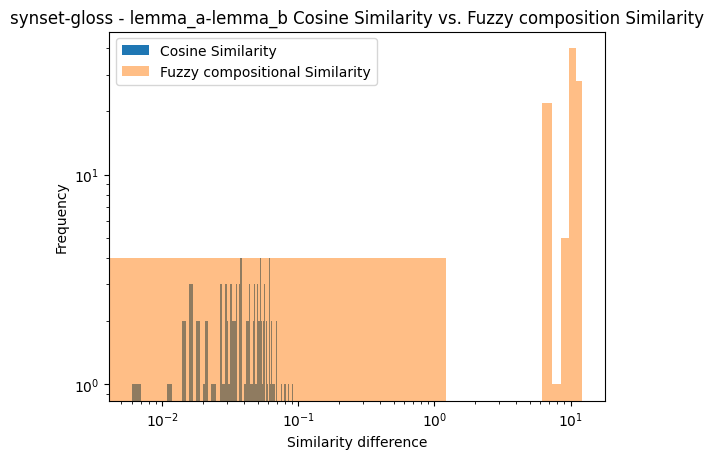

In [1210]:
eval_df["separability_fuzzy_compositional"] = eval_df["syn_gloss_fuzzy_comp_sel_int_mean_similarities"] - eval_df["gloss_gloss_fuzzy_similarities"]
plt.hist(eval_df["separability"], bins=100)
plt.hist(eval_df["separability_fuzzy_compositional"], bins=10, alpha=0.5)
plt.xlabel("Similarity difference")
plt.xscale("log")
plt.ylabel("Frequency")
plt.yscale("log")
plt.legend(["Cosine Similarity", "Fuzzy compositional Similarity"])
plt.title("synset-gloss - lemma_a-lemma_b Cosine Similarity vs. Fuzzy composition Similarity")
plt.show()

In [1211]:
# get probability mean(eval_df["separability_fuzzy"]) > 0
stats.ttest_1samp(eval_df["separability_fuzzy_compositional"], 0, alternative="greater").pvalue

np.float64(1.7261250894186766e-57)